## Spark Core 概念与操作
v0.1 notebook by 寒小阳(hanxiaoyang.ml@gmail.com)

v0.2 by 新一，新增一些重要的知识点，勘误，以及一些常用API

## Spark的核心概念
### Spark任务
- 应用程序：由一个driver program和多个job构成；
- job：由多个stage组成；
- stage：对应一个taskset；
- taskset：对应一组关联的相互之间没有shuffle依赖关系的task组成。
- task：任务最小的工作单元
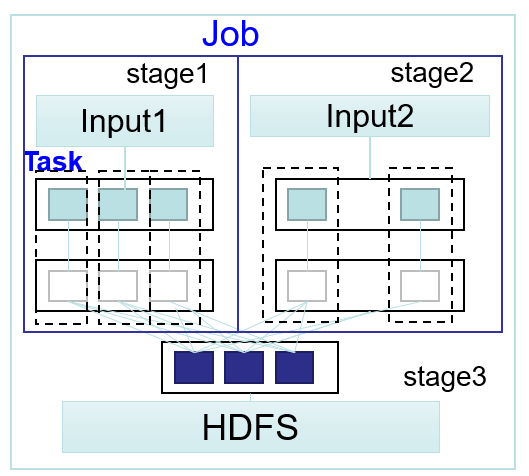



### Spark组件

- Driver Program(驱动程序): 是Spark 的核心组件
    - 构建SparkContext(Spark应用的入口,它负责和整个集群的交互，创建需要的变量，还包含集群的配置信息等)
    - 将用户提交的job转换为DAG图(类似数据处理的流程图)
    - 根据策略将DAG图划分为多个stage，根据分区从而生成一系列tasks
    - 根据tasks要求向资源管理器申请资源
    - 提交任务并检测任务状态

- Executor: 真正执行task的单元，一个Worker Node上可以有多个Executor

### 资源管理器
- YARN（最通用）
    - Master/Slave结构
    - Resource Manager(RM)全局的资源管理器，负责系统的资源管理和分配
    - Node Manager(NM) 每个节点上的资源和任务管理器
    - ApplicationMaster(AM) 每个应用程序都有一个，负责任务的调度和监视，并与RM调度器协商为任务获取资源。

- Standalone Spark自带的资源管理器，不依赖yarn，Master/Slave结构
- Mesos（初恋）


### （超纲内容）：Spark整体运行流程
- Spark的Driver Program (简称Driver)包含用户的应用程序
- Driver完成task的解析和生成
- Driver向Cluster Manager（集群资源管理器）申请运行task需要的资源。
- 集群资源管理器为task分配满足要求的节点，并在节点按照要求创建Executor
- 创建的Executor向Driver注册。
- Driver将spark应用程序的代码和文件传送给分配的executor
- executor运行task，运行完之后将结果返回给Driver或者写入HDFS或其他介质。
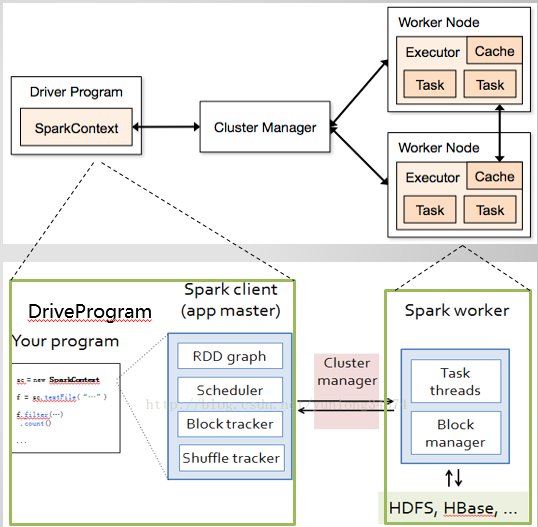

在Spark里，所有的处理和计算任务都会被组织成一系列**Resilient Distributed Dataset(弹性分布式数据集，简称RDD)**上的**transformations(转换)** 和 **actions(动作)**。

RDD是一个包含诸多元素、被划分到不同节点上进行并行处理的数据集合，可以将RDD持久化到内存中，这样就可以有效地在并行操作中复用（在机器学习这种需要反复迭代的任务中非常有效）。在节点发生错误时RDD也可以自动恢复。

说起来，RDD就像一个NumPy `array`或者一个Pandas `Series`，可以视作一个有序的item集合。<br>
只不过这些item并不存在driver端的内存里，而是被分割成很多个**partitions**，每个partition的数据存在集群的executor的内存中。

**RDD是最重要的载体，我们看看如何初始化这么一个对象**:

### 初始化RDD方法1
如果你本地内存中已经有一份序列数据(比如python的list)，你可以通过`sc.parallelize`去初始化一个RDD<br>
当你执行这个操作以后，list中的元素将被自动分块(partitioned)，并且把每一块送到集群上的不同机器上。

In [65]:
import pyspark
from pyspark import SparkContext
from pyspark import SparkConf
conf=SparkConf().setAppName("miniProject").setMaster("local[*]")
sc=SparkContext.getOrCreate(conf)
# 在内存中初始化一个RDD
rdd = sc.parallelize([1,2,3,4,5], 4)
rdd

ParallelCollectionRDD[82] at parallelize at PythonRDD.scala:175

In [66]:
# 查看该RDD被分成了多少个partition
rdd.getNumPartitions()

4

**如果你想看看分区状况怎么办**

In [67]:
rdd.glom().collect()

[[1], [2], [3], [4, 5]]

在这个例子中，是一个16-core的服务器<br>
Spark创建了16个executor，然后把数据分成16个块。

**Tips：使用`sc.parallelize`，你可以把Python list，NumPy array或者Pandas `Series`、Pandas `DataFrame`转成Spark RDD。**

### 初始化RDD方法2
第2种方式当然是直接把文本读到RDD了<br>
你的每一行都会被当做一个item，不过需要注意的一点是，**Spark一般默认你的路径是指向HDFS的，如果你要从本地读取文件的话，给一个`file://`开头的全局路径**。

In [83]:
# File from Pandas exercises
rdd = sc.textFile("file:///root/data/text1.txt")
rdd

file:///root/data/text1.txt MapPartitionsRDD[140] at textFile at <unknown>:0

In [74]:
rdd.first()

''

In [75]:
rdd.take(20)

['',
 '',
 '',
 'The Project Gutenberg EBook of Ulysses, by James Joyce',
 '',
 'This eBook is for the use of anyone anywhere at no cost and with almost',
 'no restrictions whatsoever. You may copy it, give it away or re-use',
 'it under the terms of the Project Gutenberg License included with this',
 'eBook or online at www.gutenberg.org',
 '',
 '',
 'Title: Ulysses',
 '',
 'Author: James Joyce',
 '',
 'Release Date: August 1, 2008 [EBook #4300]',
 'Last Updated: November 2, 2016',
 '',
 'Language: English',
 '']

### 其余初始化RDD的方法
RDD还可以通过其他的方式初始化，包括
* **HDFS上的文件**
* **Hive中的数据库与表**
* **Spark SQL得到的结果**

后面会提到这个部分

### <font color='red'>练习作业</font><br>
**把`/sxy-new/5642214/input/text1.txt`文件读成RDD格式的对象，命名成`text1`<br>(tips: `val fileRdd = sc.textFile("/sxy-new/5642214/input/text1.txt")`)

取出第一行（tips：`rdd.first()`)

取出前20行(tips: `rdd.take(20)`)

统计行数（tips：`rdd.count()`）**

## RDD transformation的那些事

RDDs可以进行一系列的**变换**得到新的RDD，我们先给大家提一下RDD上最最常用到的transformation:
* **`map()` 对RDD的每一个item都执行同一个操作**
* **`flatMap()` 对RDD中的item执行同一个操作以后得到一个list，然后以平铺的方式把这些list里所有的结果组成新的list**
* **`filter()` 筛选出来满足条件的item**
* **`distinct()` 对RDD中的item去重**
* **`sample()` 从RDD中的item中采样一部分出来，有放回或者无放回**
* **`sortBy()` 对RDD中的item进行排序**

**如果你想看操作后的结果，可以用一个叫做`collect()`的**action**把所有的item转成一个Python list。**

简单的例子如下:

In [52]:
numbersRDD = sc.parallelize(range(1,10+1))
print(numbersRDD.collect())

squaresRDD = numbersRDD.map(lambda x: x**2)  # Square every number
print(squaresRDD.collect())

filteredRDD = numbersRDD.filter(lambda x: x % 2 == 0)  # Only the evens
print(filteredRDD.collect())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[1, 4, 9, 16, 25, 36, 49, 64, 81, 100]
[2, 4, 6, 8, 10]


然后咱们看看**`flatMap()`**的平展功能:

In [53]:
sentencesRDD = sc.parallelize(['Hello world', 'My name is Patrick'])
wordsRDD = sentencesRDD.flatMap(lambda sentence: sentence.split(" "))
print(wordsRDD.collect())
print(wordsRDD.count())

['Hello', 'world', 'My', 'name', 'is', 'Patrick']
6


为了做一个小小的对应，咱们看看python里对应的操作大概是什么样的:

In [54]:
l = ['Hello world', 'My name is Patrick']
ll = []
for sentence in l:
    ll = ll + sentence.split(" ")
ll

['Hello', 'world', 'My', 'name', 'is', 'Patrick']

比较炫酷的是，**前面提到的Transformation，可以一个接一个地串联**，比如:

In [12]:
# [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
def doubleIfOdd(x):
    if x % 2 == 1:
        return 2 * x
    else:
        return x

resultRDD = (numbersRDD           # In parentheses so we can write each
             .map(doubleIfOdd)    # transformation in one line
             .filter(lambda x: x > 6)
             .distinct())

resultRDD.collect()

[8, 10, 18, 14]

### <font color='red'>练习作业</font><br>
**使用`sc.textFile()`载入`"/sxy-new/5642214/input/text1.txt"`到RDD中<br>
练习`map`, `filter` 和 `distinct`操作<br>
进行组合操作得到所有以M开头的名字组成的RDD<br>
tips：`first()` 这个action也许可以在中间的某些部分帮助到你**
``` scala
val fileRdd = sc.textFile("/sxy-new/5642214/input/text1.txt")
val words = fileRdd.flatMap(_.split(" "))
val mWords = words.filter(_.startsWith("M"))
```

## RDD间的操作

如果你手头上有2个RDD了，下面的这些操作能够帮你对他们以个种方式组合得到1个RDD:
* **`rdd1.union(rdd2)`: 所有`rdd1`和`rdd2`中的item组合**
* **`rdd1.intersection(rdd2)`: `rdd1` 和 `rdd2`的交集**
* **`rdd1.substract(rdd2)`: 所有在`rdd1`中但不在`rdd2`中的item（差集）**
* **`rdd1.cartesian(rdd2)`: `rdd1` 和 `rdd2`中所有的元素笛卡尔乘积 **

简单的例子如下:

In [13]:
numbersRDD = sc.parallelize([1,2,3])
moreNumbersRDD = sc.parallelize([2,3,4])

In [14]:
numbersRDD.union(moreNumbersRDD).collect()

[1, 2, 3, 2, 3, 4]

In [15]:
numbersRDD.intersection(moreNumbersRDD).collect()

[2, 3]

In [16]:
numbersRDD.subtract(moreNumbersRDD).collect()

[1]

In [17]:
numbersRDD.cartesian(moreNumbersRDD).collect()

[(1, 2), (1, 3), (1, 4), (2, 2), (2, 3), (2, 4), (3, 2), (3, 3), (3, 4)]

**特别注意**：Spark的一个核心概念是**惰性计算**。当你把一个RDD转换成另一个的时候，这个转换不会立即生效执行！！！<br>Spark会把它先记在心里，等到真的需要拿到转换结果的时候，才会重新组织你的transformations(因为可能有一连串的变换)<br>
这样可以避免不必要的中间结果存储和通信。

刚才提到了**惰性计算**，那么什么东西能让它真的执行转换与运算呢？
是的，就是我们马上提到的**Actions**，下面是常见的action，当他们出现的时候，表明我们需要执行刚才定义的transform了:
* `collect()`: 计算所有的items并返回所有的结果到driver端，接着 `collect()`会以Python list的形式返回结果
* `first()`: 和上面是类似的，不过只返回第1个item
* `take(n)`: 类似，但是返回n个item
* `count()`: 计算RDD中item的个数
* `top(n)`: 返回头n个items，按照自然结果排序
* `reduce()`: 对RDD中的items做聚合
* `saveAsTextFile()`：方法接收一个路径，并将RDD 中的内容都输入到路径对应的文件中。
* `foreach()`: 做定制化的想做的操作

我们之前已经看过 `collect()`, `first()` 和 `count()` 的例子了。  咱们看看 `reduce()` 如何使用。比如Spark里从1加到10你可以这么做。

In [55]:
# [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
rdd = sc.parallelize(range(1,10+1))
rdd.reduce(lambda x, y: x + y)

55

如果你想了解一下`reduce`的细节的话，其实可能会先在每个分区(partition)里完成reduce操作，然后再全局地进行reduce。<br>
这个过程你可以从如下的代码大致理解。

In [56]:
def f(x,y):
    return x + y

l = [1,2,3,4]
f(f(f(l[0],l[1]), l[2]), l[3])

10

In [20]:
f(f(l[0], l[1]),  f(l[2], l[3]))

10

### <font color='red'>练习作业</font><br>
1. **在Spark里使用`reduce()`计算10!**
``` scala
val rdd = sc.parallelize(1 to 10)
rdd.reduce(_ * _)
```

In [82]:
rdd = sc.parallelize(range(1,10+1))
rdd.reduce(lambda x,y: x*y)

3628800

**用`reduce()`操作创建一个字符串，内容是前面练习中所有以M开头的名字list以逗号分隔开**

有一个很有用的操作，我们试想一下，有时候我们需要重复用到某个transform序列得到的RDD结果。但是一遍遍重复计算显然是要开销的，所以我们可以通过一个叫做`cache()`的操作把它暂时地存储在内存中:

In [21]:
# Calculate the average of all the squares from 1 to 10
import numpy as np
numbersRDD = sc.parallelize(np.linspace(1.0, 10.0, 10))
squaresRDD = numbersRDD.map(lambda x: x**2)

squaresRDD.cache()  # Preserve the actual items of this RDD in memory

avg = squaresRDD.reduce(lambda x, y: x + y) / squaresRDD.count()
print(avg)

38.5


缓存RDD结果对于重复迭代的操作非常有用，比如很多机器学习的算法，训练过程需要重复迭代。

## 针对更复杂结构的transform和action
咱们刚才已经见识到了`Spark`中最常见的transform和action，但是有时候我们会遇到更复杂的结构，比如非常非常经典的是以元组形式组织的k-v对（key, value）<br>
我们把它叫做**pair RDDs**，而Spark中针对这种item结构的数据，定义了一些transform和action:
* `reduceByKey()`: 对所有有着相同key的items执行reduce操作
* `groupByKey()`: 返回类似(key, listOfValues)元组的RDD，后面的value List 是同一个key下面的
* `sortByKey()`: 按照key排序
* `countByKey()`: 按照key去对item个数进行统计
* `collectAsMap()`: 和collect有些类似，但是返回的是k-v的字典

以下是Spark中的一些例子<br>
怎么说呢，统计这个案例算是分布式（hadoop/spark）相关知识中的“Hello World”

In [57]:
rdd = sc.parallelize(["Hello hello", "Hello New York", "York says hello"])
resultRDD = (
    rdd
    .flatMap(lambda sentence: sentence.split(" "))  # split into words
    .map(lambda word: word.lower())                 # lowercase
    .map(lambda word: (word, 1))                    # count each appearance
    .reduceByKey(lambda x, y: x + y)                # add counts for each word
)
resultRDD.collect()

[('new', 1), ('hello', 4), ('york', 2), ('says', 1)]

我们将结果以k-v字典的形式返回

In [23]:
result = resultRDD.collectAsMap()
result

{'hello': 4, 'new': 1, 'says': 1, 'york': 2}

如果你想要出现频次最高的2个词，可以这么做:

In [24]:
print(resultRDD
      .sortBy(keyfunc=lambda (word, count): count, ascending=False)
      .take(2))

[('hello', 4), ('york', 2)]


### <font color='red'>练习作业</font><br>
**使用Spark2. 在spark里计算M开头的单词的 wordcount，并输出到hdfs中`/sxy-new/5642214/output/3`**
```
val mWordsPair = mWords.map(each => (each, 1))
val mWordsCount = mWordsPair.reduceByKey(_ + _)
mWordsCount.saveAsTextFile("/sxy-new/5642214/output/3")

```

还有一个很有意思的操作是，在给定2个RDD后，我们可以通过一个类似SQL的方式去join他们。

In [76]:
# Home of different people
homesRDD = sc.parallelize([
        ('Brussels', 'John'),
        ('Brussels', 'Jack'),
        ('Leuven', 'Jane'),
        ('Antwerp', 'Jill'),
    ])

# Quality of life index for various cities
lifeQualityRDD = sc.parallelize([
        ('Brussels', 10),
        ('Antwerp', 7),
        ('RestOfFlanders', 5),
    ])

In [77]:
homesRDD.join(lifeQualityRDD).collect()

[('Antwerp', ('Jill', 7)),
 ('Brussels', ('John', 10)),
 ('Brussels', ('Jack', 10))]

In [78]:
homesRDD.leftOuterJoin(lifeQualityRDD).collect()

[('Antwerp', ('Jill', 7)),
 ('Brussels', ('John', 10)),
 ('Brussels', ('Jack', 10)),
 ('Leuven', ('Jane', None))]

In [81]:
homesRDD.rightOuterJoin(lifeQualityRDD).collect()

[('Antwerp', ('Jill', 7)),
 ('RestOfFlanders', (None, 5)),
 ('Brussels', ('John', 10)),
 ('Brussels', ('Jack', 10))]

## pySpark代码的编写与集群作业提交
### pySpark代码的编写
以wordcount为例

``` python
# -*- coding: utf-8 -*-  
from __future__ import print_function

import sys
from operator import add

from pyspark.sql import SparkSession


if __name__ == "__main__":
    if len(sys.argv) != 3:
        print("Usage: wordcount <inputfile> <outputfile>", file=sys.stderr)
        sys.exit(-1)

    spark = SparkSession\
        .builder\
        .appName("PythonWordCount")\
        .getOrCreate()

    lines = spark.read.text(sys.argv[1]).rdd.map(lambda r: r[0])
    counts = lines.flatMap(lambda x: x.split(' ')) \
                  .map(lambda x: (x, 1)) \
                  .reduceByKey(add)
    counts.saveAsTextFile(sys.argv[2])

    spark.stop()
```

### 在集群提交你的spark作业

集群提交命令一般遵循如下模式：
``` sh
./bin/spark-submit \
  --class <main-class> \ ## 主函数
  --master <master-url> \
  --deploy-mode <deploy-mode> \
  --conf <key>=<value> \
  ... # other options
  <application-jar> \
  [application-arguments]
```
``` sh
spark-submit --master yarn --deploy-mode client wordcount.py /sxy-new/5642214/input/* /sxy-new/5642214/output/5
```